In [1]:
from sklearn.datasets import fetch_openml

bikes = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
X, y = bikes.data.copy(), bikes.target

In [2]:
X["weather"] = (
    X["weather"]
    .astype(object)
    .replace(to_replace="heavy_rain", value="rain")
    .astype("category")
)


In [3]:
mask_training = X["year"] == 0.0
X = X.drop(columns=["year"])
X_train, y_train = X[mask_training], y[mask_training]
X_test, y_test = X[~mask_training], y[~mask_training]

In [4]:
numerical_features = [
    "temp",
    "feel_temp",
    "humidity",
    "windspeed",
]
categorical_features = X_train.columns.drop(numerical_features)

In [5]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

hgbdt_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    sparse_threshold=1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")


In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
from time import time
from sklearn.pipeline import make_pipeline

hgbdt_model = make_pipeline(
    hgbdt_preprocessor,
    HistGradientBoostingRegressor(
        categorical_features=categorical_features,
        random_state=42,
        max_iter=100,
    ),
)
hgbdt_model.fit(X_train, y_train)

Computing partial dependence plots...


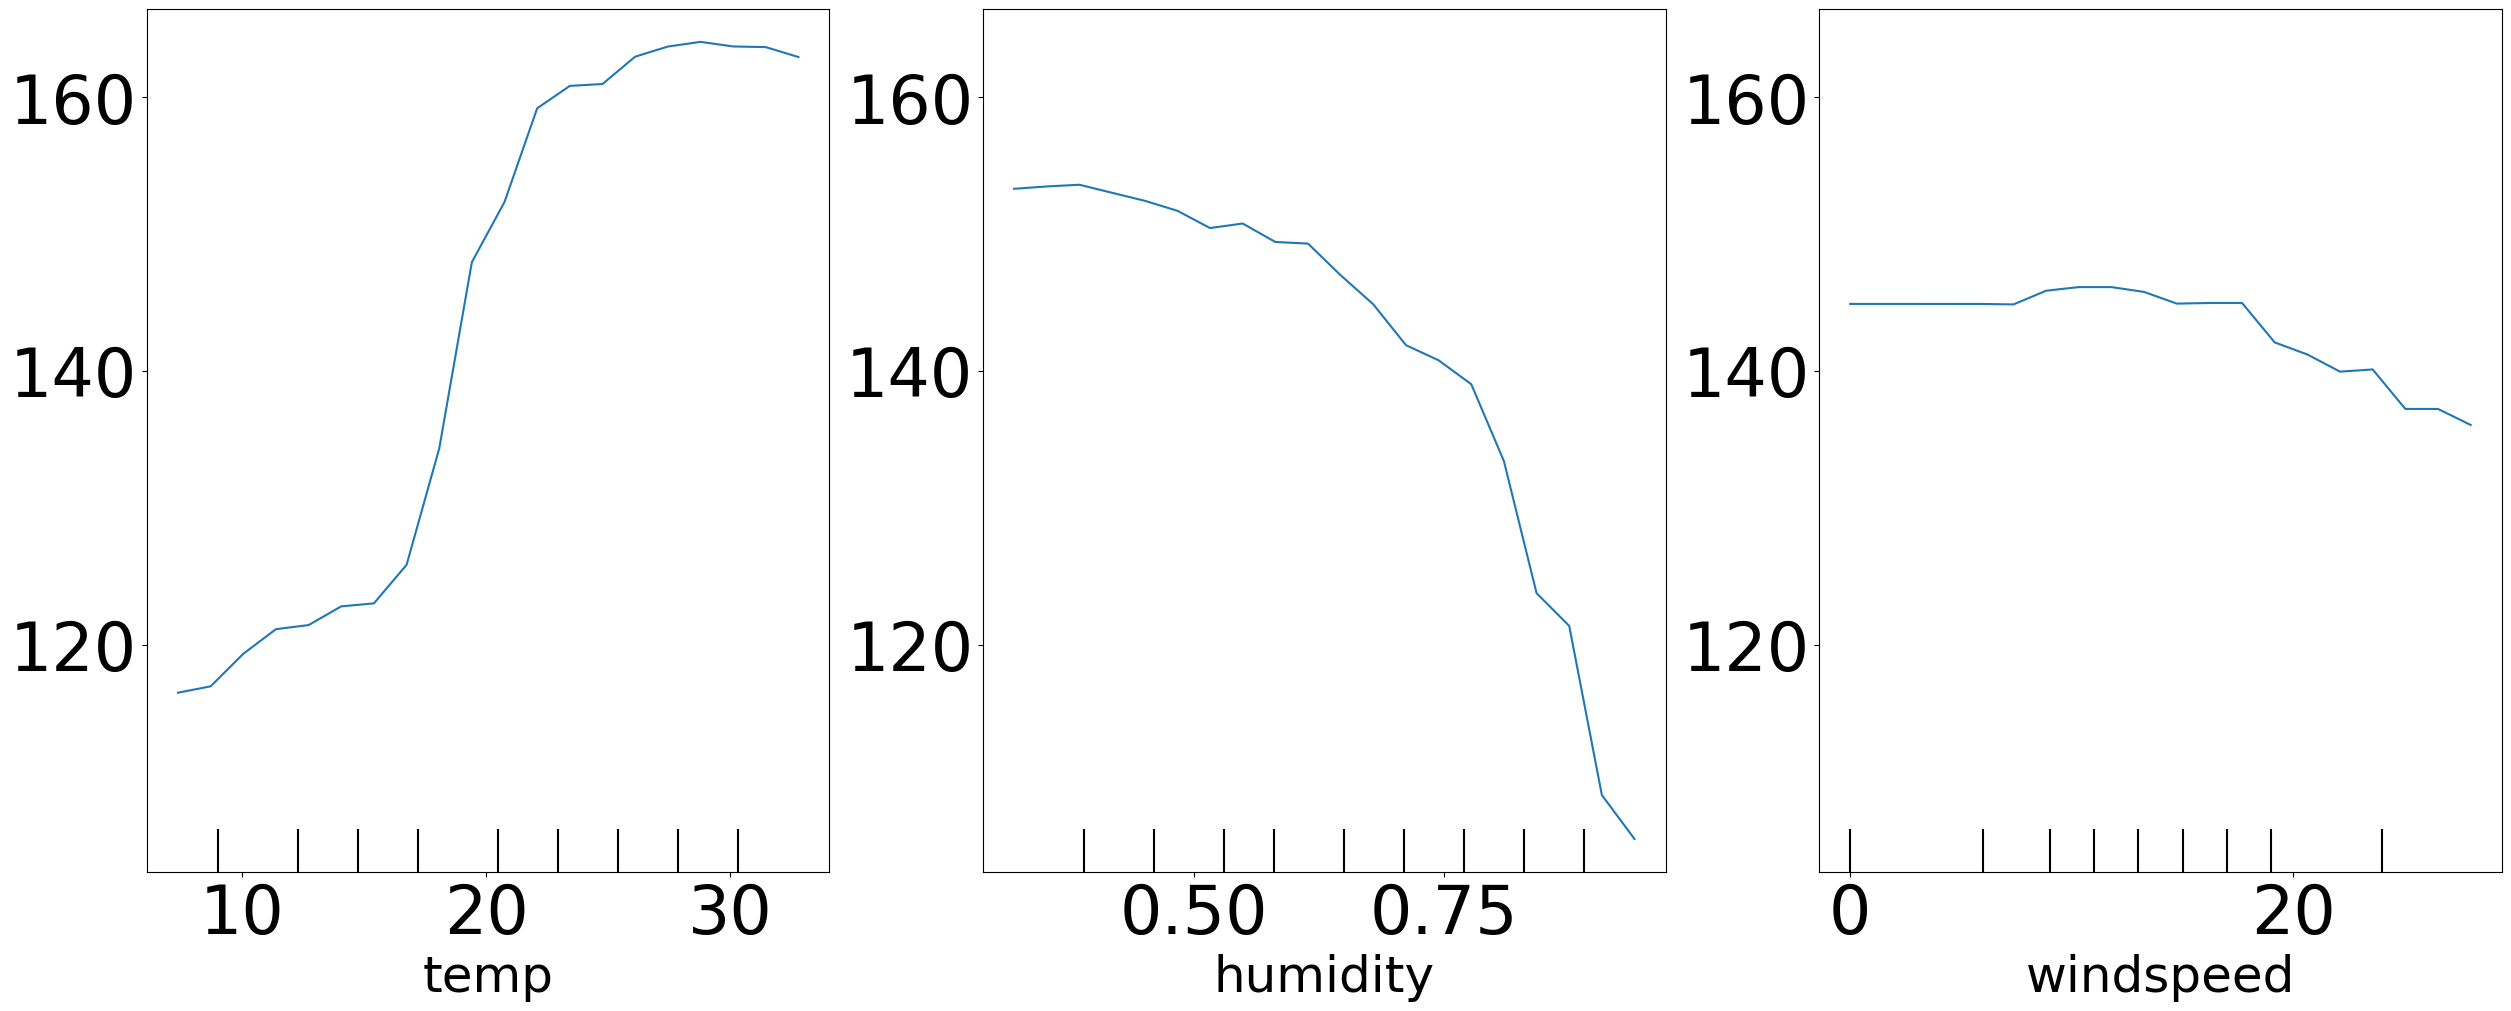

In [7]:
import matplotlib.pyplot as plt
import numpy as np


from sklearn.inspection import PartialDependenceDisplay

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 42,
}

print("Computing partial dependence plots...")
features_info = {
    "features": ["temp", "humidity", "windspeed"],
    # type of partial dependence plot
    "kind": "average",
    "categorical_features": categorical_features,
}

plt.rc('xtick', labelsize=48)
plt.rc('ytick', labelsize=48)
plt.rc('font', size=36)

_, ax = plt.subplots(ncols=3, nrows=1, figsize=(25, 10), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    hgbdt_model,
    X_train,
    **features_info,
    ax=ax,
    **common_params,
)
for a in ax:
    a.set(ylabel="")
plt.savefig("pdp.pdf")